# **Time Series Regression - A Machine Learning Approach For Coporation Favorita**

### Table of Contents
1. [Business Understanding](#business-understanding)
2. [Data collection](#Data-collection)
3. [Data Cleaning and Preparation](#Data-Cleaning-and-Preparation)
4. [Hypotheses](#hypotheses)
5. [Analytical Questions](#analytical-questions)
6. [Data Sources](#data-sources)
7. [Process Overview](#process-overview)

## **Business Understanding**

Corporation Favorita, a large grocery retailer based in Ecuador, aims to optimize its inventory management to ensure the right quantity of products is always in stock across its various locations. Effective inventory management is critical for maintaining high levels of customer satisfaction and minimizing costs associated with overstocking or stockouts.

To achieve this goal, we will build machine learning models to forecast the demand for products at different Favorita stores. Accurate demand forecasting will allow Corporation Favorita to make informed decisions regarding stock levels, promotions, and supply chain logistics.

#### Objective:
1. **Develop Predictive Models**: Create models to forecast daily unit sales for thousands of products across multiple stores.
2. **Understand Influencing Factors**: Analyze the impact of various factors on sales, including promotions, holidays, oil prices, store characteristics, and external events such as earthquakes.
3. **Optimize Inventory Management**: Use the models to inform inventory decisions, ensuring that the right products are available at the right stores at the right time.

#### Hypothesis:
1. Null Hypothesis (H0): Promotions do not have a significant impact on sales.  
   Alternative Hypothesis (H1): Promotions have a significant impact on sales.
2. Null Hypothesis (H0): Oil prices do not significantly impact sales.  
   Alternative Hypothesis (H1): Oil prices significantly impact sales.

#### Key Analytical Questions:
1. **Data Completeness**: Is the training dataset complete with all required dates?
2. **Sales Extremes**: Which dates have the lowest and highest sales for each year (excluding days when stores were closed)?
3. **Monthly Sales Trends**: Compare sales across months and years to identify the highest sales month and year.
4. **Earthquake Impact**: Did the earthquake in April 2016 impact sales?
5. **Store Performance**: Are certain stores or groups of stores (cluster, city, state, type) selling more products?
6. **Promotions, Oil Prices, and Holidays**: How are sales affected by promotions, oil prices, and holidays?
7. **Date Features Analysis**: What insights can be derived from date-related features?
8. **Promotion Impact**: Which product families and stores were most affected by promotions?
9. **Error Metrics**: What is the difference between RMSLE, RMSE, and MSE? Why might MAE be greater than these metrics?
10. **Wage Payment Influence**: Does the bi-monthly payment of public sector wages influence store sales?


#### Data Sources
- **train.csv**: Time series data of store, product information, promotions, and sales.
- **test.csv**: Features similar to the training data for the 15 days following the last date in the training data.
- **transaction.csv**: Daily transactions per store.
- **stores.csv**: Metadata about stores including location and type.
- **oil.csv**: Daily oil prices.
- **holidays_events.csv**: Information about holidays and events, including special designations like transferred, bridge, and work days.
- **sample_submission.csv**: A sample submission file for formatting predictions.





# Import Necessary Packages

In [30]:
import pyodbc
from dotenv import dotenv_values
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from scipy import stats
from matplotlib.ticker import FuncFormatter
from scipy.stats import ttest_ind
import statsmodels.api as sm
import matplotlib.ticker as ticker

import warnings
warnings.filterwarnings('ignore')

# Seaborn color palette
palette = sns.color_palette("tab10")

# Function to format y-axis labels in millions
def millions(x, pos):
    return '%1.0fM' % (x * 1e-6)

In [3]:
 #Load environment variables from .env file
environment_variables = dotenv_values('.env')

# Get the values for the credentials set in the .env file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

# Create a connection string
connection_string = f"DRIVER={{SQL Server}}; \
                    SERVER={server}; \
                    DATABASE={database}; \
                    UID={username}; \
                    PWD={password};"

# Connect to the server
connection = pyodbc.connect(connection_string)

# Load Data From Database

In [4]:
oil = pd.read_sql_query("SELECT * FROM dbo.oil", connection)

# Save the DataFrame to a CSV file
oil.to_csv('data/oil.csv', index=False)

oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [5]:
# Load holidays_events dataset
holidays_events = pd.read_sql_query(
    "SELECT * FROM dbo.holidays_events", connection)

# Save the DataFrame to a CSV file
holidays_events.to_csv('data/holidays_events.csv', index=False)

holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [6]:
# Load stores dataset
stores = pd.read_sql_query("SELECT * FROM dbo.stores", connection)

# Save the DataFrame to a CSV file
stores.to_csv('data/stores.csv', index=False)

stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [7]:
train = pd.read_csv('Data/train.csv')

train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [8]:
test = pd.read_csv('Data/test.csv')

test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [9]:
transactions = pd.read_csv('Data/transactions.csv')

transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [10]:
sample_submission = pd.read_csv('Data/sample_submission.csv')

sample_submission.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


# **Data Preparation and Cleaning**


1. **Handle Missing Values**

In [12]:
# Check for missing values in each dataset
missing_train = train.isnull().sum()
missing_test = test.isnull().sum()
missing_transactions = transactions.isnull().sum()
missing_stores = stores.isnull().sum()
missing_oil = oil.isnull().sum()
missing_holidays_events = holidays_events.isnull().sum()

missing_train, missing_test, missing_transactions, missing_stores, missing_oil, missing_holidays_events

(id             0
 date           0
 store_nbr      0
 family         0
 sales          0
 onpromotion    0
 dtype: int64,
 id             0
 date           0
 store_nbr      0
 family         0
 onpromotion    0
 dtype: int64,
 date            0
 store_nbr       0
 transactions    0
 dtype: int64,
 store_nbr    0
 city         0
 state        0
 type         0
 cluster      0
 dtype: int64,
 date           0
 dcoilwtico    43
 dtype: int64,
 date           0
 type           0
 locale         0
 locale_name    0
 description    0
 transferred    0
 dtype: int64)

In [13]:
# Fill missing values in the oil dataset using forward fill
oil['dcoilwtico'].fillna(method='ffill', inplace=True)

# Verify that there are no more missing values
missing_values_oil = oil.isnull().sum()
missing_values_oil

date          0
dcoilwtico    1
dtype: int64

2. **Correct Data Types**

In [14]:
# Convert date columns to datetime format
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
transactions['date'] = pd.to_datetime(transactions['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays_events['date'] = pd.to_datetime(holidays_events['date'])

3. **Merge Datasets**


In [15]:
# Merge train dataset with transactions, stores, oil, and holidays_events
train_merged = train.merge(transactions, on=['date', 'store_nbr'], how='left')
train_merged = train_merged.merge(stores, on='store_nbr', how='left')
train_merged = train_merged.merge(oil, on='date', how='left')
train_merged = train_merged.merge(holidays_events, on='date', how='left')

# Repeat the same for the test dataset
test_merged = test.merge(transactions, on=['date', 'store_nbr'], how='left')
test_merged = test_merged.merge(stores, on='store_nbr', how='left')
test_merged = test_merged.merge(oil, on='date', how='left')
test_merged = test_merged.merge(holidays_events, on='date', how='left')

In [16]:
#Necessary rename
train_merged.rename(columns={'type_x': 'store_type','type_y': 'holiday_type'}, inplace=True)
test_merged.rename(columns={'type_x': 'store_type','type_y': 'holiday_type'}, inplace=True)

In [17]:
# Fill null values in transactions with 0
train_merged['transactions'].fillna(0, inplace=True)
test_merged['transactions'].fillna(0, inplace=True)

# Forward filling and backward filling for dcoilwtico
train_merged['dcoilwtico'].fillna(method='ffill', inplace=True)
train_merged['dcoilwtico'].fillna(method='bfill', inplace=True)

test_merged['dcoilwtico'].fillna(method='ffill', inplace=True)
test_merged['dcoilwtico'].fillna(method='bfill', inplace=True)

# Fill holiday-related columns with 'None'
holiday_related_cols = ['holiday_type', 'locale','locale_name', 'description', 'transferred']
train_merged[holiday_related_cols] = train_merged[holiday_related_cols].fillna('None')
test_merged[holiday_related_cols] = test_merged[holiday_related_cols].fillna('None')

4. **Create Date Features**

In [18]:
# Create additional features from the date
train_merged['year'] = train_merged['date'].dt.year
train_merged['month'] = train_merged['date'].dt.month
train_merged['day'] = train_merged['date'].dt.day
train_merged['dayofweek'] = train_merged['date'].dt.dayofweek

test_merged['year'] = test_merged['date'].dt.year
test_merged['month'] = test_merged['date'].dt.month
test_merged['day'] = test_merged['date'].dt.day
test_merged['dayofweek'] = test_merged['date'].dt.dayofweek

# ** Exploratory Data Analysis(EDA)**


In [19]:
# # Group by date and sum sales to get the overall sales trend over time
# sales_trend = train_merged.groupby('date')['sales'].sum().reset_index()

# # Group by year and month for monthly trend
# sales_trend['year_month'] = sales_trend['date'].dt.to_period('M')
# monthly_sales_trend = sales_trend.groupby(
#     'year_month')['sales'].sum().reset_index()

# # Group by year for yearly trend
# sales_trend['year'] = sales_trend['date'].dt.year
# yearly_sales_trend = sales_trend.groupby('year')['sales'].sum().reset_index()

In [ ]:
# # Plot overall sales trend
# plt.figure(figsize=(14, 7))
# plt.plot(sales_trend['date'], sales_trend['sales'],
#          color=palette[0], linewidth=1, label='Daily Sales')
# plt.title('Overall Sales Trend Over Time', fontsize=16)
# plt.xlabel('Date', fontsize=14)
# plt.ylabel('Total Sales', fontsize=14)
# plt.tick_params(axis='both', which='major', labelsize=12)

# # Format y-axis to avoid exponents
# plt.gca().get_yaxis().get_major_formatter().set_scientific(False)

# # Add a trend line for better visualization
# z = np.polyfit(sales_trend['date'].apply(lambda x: x.toordinal()), sales_trend['sales'], 1)
# p = np.poly1d(z)
# plt.plot(sales_trend['date'], p(sales_trend['date'].apply(lambda x: x.toordinal())), 
#          color=palette[1], linestyle='--', linewidth=2, label='Trend Line')

# plt.legend()
# plt.show()

In [20]:
# # Plot yearly sales trend
# plt.figure(figsize=(14, 7))
# plt.plot(yearly_sales_trend['year'], yearly_sales_trend['sales'],
#          color=palette[0], linewidth=2, label='Yearly Sales')
# plt.title('Yearly Sales Trend', fontsize=16)
# plt.xlabel('Year', fontsize=14)
# plt.ylabel('Total Sales', fontsize=14)
# plt.tick_params(axis='both', which='major', labelsize=12)

# plt.gca().get_yaxis().set_major_formatter(FuncFormatter(millions))

# plt.legend()
# plt.show()

** Sales Distribution Across Stores and Product Families**

In [21]:
# # Aggregate sales by store and product family
# store_sales = train_merged.groupby('store_nbr')['sales'].sum(
# ).sort_values(ascending=False).reset_index()
# family_sales = train_merged.groupby(
#     'family')['sales'].sum().sort_values(ascending=False).reset_index()

# # Plot sales distribution across stores
# plt.figure(figsize=(14, 7))
# plt.bar(store_sales['store_nbr'], store_sales['sales'])
# plt.xlabel('Store Number')
# plt.ylabel('Total Sales')
# plt.title('Sales Distribution Across Stores')
# plt.show()

In [22]:
# # Plot sales distribution across product families
# plt.figure(figsize=(14, 7))
# plt.barh(family_sales['family'], family_sales['sales'])
# plt.xlabel('Total Sales')
# plt.ylabel('Product Family')
# plt.title('Sales Distribution Across Product Families')
# plt.show()

**Impact Of Promotions**

In [23]:
# # Aggregate sales by promotion status
# promotion_sales = train_merged.groupby(
#     'onpromotion')['sales'].sum().reset_index()

# # Plot impact of promotions on sales
# plt.figure(figsize=(10, 6))
# plt.bar(promotion_sales['onpromotion'],
#         promotion_sales['sales'], color=['blue', 'orange'])
# plt.xlabel('On Promotion')
# plt.ylabel('Total Sales')
# plt.title('Impact of Promotions on Sales')
# plt.xticks([0, 1], ['No', 'Yes'])
# plt.show()

**Impact of Oil Prices**

In [24]:
# # Plot sales versus oil prices
# plt.figure(figsize=(14, 7))
# plt.plot(train_merged['date'], train_merged['sales'], label='Sales')
# plt.plot(train_merged['date'], train_merged['dcoilwtico'],
#          label='Oil Price', color='orange')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.title('Sales vs Oil Prices')
# plt.legend()
# plt.show()

**Impact of Holidays**

In [25]:
# # Aggregate sales by holiday status
# holiday_sales = train_merged.groupby(
#     'holiday_type')['sales'].sum().reset_index()

# # Plot impact of holidays on sales
# plt.figure(figsize=(14, 7))
# plt.bar(holiday_sales['holiday_type'], holiday_sales['sales'], color='green')
# plt.xlabel('Holiday Type')
# plt.ylabel('Total Sales')
# plt.title('Impact of Holidays on Sales')
# plt.xticks(rotation=45)
# plt.show()

# **Hypothesis Testing**

**Null Hypothesis(HOa)** : Promotions do not have a significant impact on sales.

**Alternative Hypothesis(H1a)** : Promotions have a significant impact on sales.

In [26]:
# Split data into promotional and non-promotional periods
promotional_sales = train[train['onpromotion'] > 0]['sales']
non_promotional_sales = train[train['onpromotion'] == 0]['sales']

# Calculate descriptive statistics
promotional_mean = promotional_sales.mean()
non_promotional_mean = non_promotional_sales.mean()
promotional_std = promotional_sales.std()
non_promotional_std = non_promotional_sales.std()

print(f"Promotional Sales - Mean: {promotional_mean}, Std: {promotional_std}")
print(f"Non-Promotional Sales - Mean: {non_promotional_mean}, Std: {non_promotional_std}")


Promotional Sales - Mean: 1137.6937303133943, Std: 1928.5887066373123
Non-Promotional Sales - Mean: 158.2466813936427, Std: 614.8944509454778


In [27]:
# Perform t-test
t_stat, p_value = ttest_ind(promotional_sales, non_promotional_sales)

print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("We Reject the null hypothesis (H0a). Promotions have a significant impact on sales.")
else:
    print("Fail to reject the null hypothesis (H0a). Promotions do not have a significant impact on sales.")

T-Statistic: 664.1236909096903, P-Value: 0.0
We Reject the null hypothesis (H0a). Promotions have a significant impact on sales.


**Null Hypothesis(HOb)** : Oil prices do not significantly impact sales.

**Alternative Hypothesis(H1b)** : Oil prices significantly impact Sales.

In [28]:
# Remove rows with missing oil prices
oil_merged_data = train_merged.dropna(subset=['dcoilwtico'])

# Perform correlation analysis
correlation = oil_merged_data['sales'].corr(oil_merged_data['dcoilwtico'])
print(f"Correlation between sales and oil prices: {correlation}")

Correlation between sales and oil prices: -0.07542992345237809


In [31]:
# Perform linear regression analysis
X = oil_merged_data['dcoilwtico']
y = oil_merged_data['sales']
X = sm.add_constant(X)  # Adds a constant term to the predictor

model = sm.OLS(y, X).fit()
summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                 1.748e+04
Date:                Sat, 03 Aug 2024   Prob (F-statistic):               0.00
Time:                        22:03:21   Log-Likelihood:            -2.5735e+07
No. Observations:             3054348   AIC:                         5.147e+07
Df Residuals:                 3054346   BIC:                         5.147e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        579.8744      1.786    324.672      0.0

In [32]:
# Extract the p-value for the oil price coefficient
p_value = model.pvalues['dcoilwtico']
print(f"P-Value for oil prices: {p_value}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis (H0b). Oil prices significantly impact sales.")
else:
    print("Fail to reject the null hypothesis (H0b). Oil prices do not significantly impact sales.")

P-Value for oil prices: 0.0
Reject the null hypothesis (H0b). Oil prices significantly impact sales.


# ** Analytical Questions**

1. **Check if train dataset has all required dates**

In [33]:
# Determine the start and end dates in the train dataset
start_date = train['date'].min()
end_date = train['date'].max()

# Create a complete date range from start to end date
complete_date_range = pd.date_range(start=start_date, end=end_date)

# Extract the unique dates from the train dataset
unique_dates_in_train = train['date'].unique()

# Find any missing dates by comparing the complete date range to the dates in the train dataset
missing_dates = set(complete_date_range) - set(unique_dates_in_train)

print(f"Start Date in Train Dataset: {start_date}")
print(f"End Date in Train Dataset: {end_date}")
print(f"Number of Unique Dates in Train Dataset: {len(unique_dates_in_train)}")
print(f"Number of Dates in Complete Range: {len(complete_date_range)}")
print(f"Missing Dates: {sorted(missing_dates)}")

Start Date in Train Dataset: 2013-01-01 00:00:00
End Date in Train Dataset: 2017-08-15 00:00:00
Number of Unique Dates in Train Dataset: 1684
Number of Dates in Complete Range: 1688
Missing Dates: [Timestamp('2013-12-25 00:00:00'), Timestamp('2014-12-25 00:00:00'), Timestamp('2015-12-25 00:00:00'), Timestamp('2016-12-25 00:00:00')]


In [34]:
# Create variables as arguments for the product() method
uniques_stores = train_merged.store_nbr.unique()
unique_family = train_merged.family.unique()

In [35]:
# Replace the missing dates by pairing it with all the unique stores and families
replace_dates = list(product(missing_dates, uniques_stores,unique_family ))

In [36]:
 #Create a dataframe for the replaced dates
replace_dates_df = pd.DataFrame(replace_dates, columns=['date', 'store_nbr', 'family'])
replace_dates_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7128 entries, 0 to 7127
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       7128 non-null   datetime64[ns]
 1   store_nbr  7128 non-null   int64         
 2   family     7128 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 167.2+ KB


In [37]:
 #Add replaced dates to our train data
train_merged = pd.concat([train_merged, replace_dates_df], ignore_index=True)

missing_dates = pd.date_range(start='2013-01-01', end='2017-08-15').difference(train_merged.date)
missing_dates

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

2.**Determine which dates have the lowest and highest sales for each year(excluding days the store was closed)**

In [38]:
# Identify dates when stores were closed (i.e., zero transactions)
closed_dates = transactions[transactions['transactions'] == 0]['date'].unique()

# Filter out closed dates from the sales data
sales_data = train_merged[~train_merged['date'].isin(closed_dates)]

In [40]:
# Initialize dictionaries to store the results
lowest_sales_dates = {}
highest_sales_dates = {}

# Group by year and find the dates with the lowest and highest sales
for year, group in sales_data.groupby('year'):
    lowest_sales_row = group.loc[group['sales'].idxmin()]
    highest_sales_row = group.loc[group['sales'].idxmax()]
    lowest_sales_dates[year] = (lowest_sales_row['date'], lowest_sales_row['sales'])
    highest_sales_dates[year] = (highest_sales_row['date'], highest_sales_row['sales'])

# Create DataFrames to display the results
lowest_sales_df = pd.DataFrame(list(lowest_sales_dates.items()), 
                               columns=['Year', 'Lowest Sales Data'])
highest_sales_df = pd.DataFrame(list(highest_sales_dates.items()), 
                                columns=['Year', 'Highest Sales Data'])

# Split the tuple into separate columns
lowest_sales_df[['Lowest Sales Date', 'Lowest Sales']] = pd.DataFrame(
    lowest_sales_df['Lowest Sales Data'].tolist(), index=lowest_sales_df.index)
highest_sales_df[['Highest Sales Date', 'Highest Sales']] = pd.DataFrame(
    highest_sales_df['Highest Sales Data'].tolist(), index=highest_sales_df.index)

# Drop the original tuple columns
lowest_sales_df.drop(columns=['Lowest Sales Data'], inplace=True)
highest_sales_df.drop(columns=['Highest Sales Data'], inplace=True)

print("Dates with the Lowest Sales for Each Year:")
print(lowest_sales_df)
print("\nDates with the Highest Sales for Each Year:")
print(highest_sales_df)

Dates with the Lowest Sales for Each Year:
     Year Lowest Sales Date  Lowest Sales
0  2013.0        2013-01-01           0.0
1  2014.0        2014-01-01           0.0
2  2015.0        2015-01-01           0.0
3  2016.0        2016-01-01           0.0
4  2017.0        2017-01-01           0.0

Dates with the Highest Sales for Each Year:
     Year Highest Sales Date  Highest Sales
0  2013.0         2013-11-12      46271.000
1  2014.0         2014-12-08      45361.000
2  2015.0         2015-12-14      40351.460
3  2016.0         2016-05-02     124717.000
4  2017.0         2017-04-02      38422.625


3.**Compare the sales for each month across the years and determine which month of which year had the highest sales.**

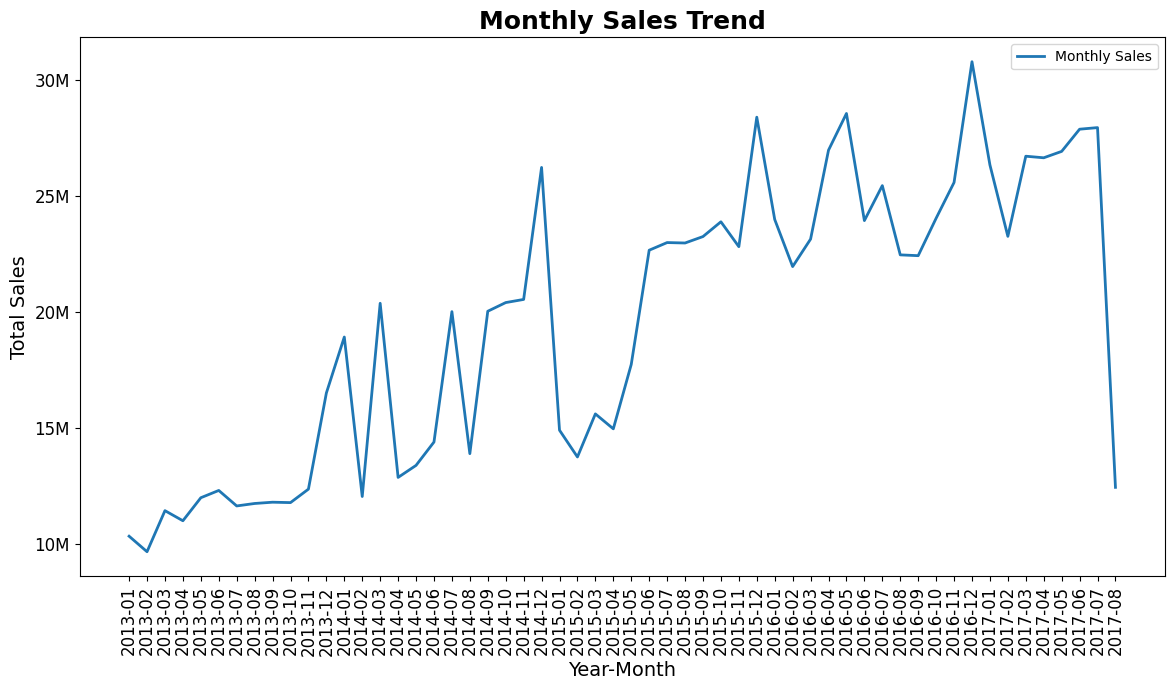

In [41]:
 #Group by date and sum sales to get the overall sales trend over time
sales_trend = train_merged.groupby('date')['sales'].sum().reset_index()

# Group by year and month for monthly trend
sales_trend['year_month'] = sales_trend['date'].dt.to_period('M')
monthly_sales_trend = sales_trend.groupby('year_month')['sales'].sum().reset_index()


# Plot monthly sales trend
plt.figure(figsize=(14, 7))
plt.plot(monthly_sales_trend['year_month'].astype(str),
         monthly_sales_trend['sales'], color=palette[0], linewidth=2, label='Monthly Sales')
plt.title('Monthly Sales Trend', fontsize=18, weight='bold')
plt.xlabel('Year-Month', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xticks(rotation=90)

# Format y-axis exponents
plt.gca().get_yaxis().set_major_formatter(FuncFormatter(millions))

plt.legend()
plt.show()